In [1]:
%pylab inline

import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder

import lightgbm as lgb
import xgboost as xgb

pd.set_option('display.max_columns', 500)

import locale
locale.setlocale(locale.LC_ALL, 'ru_RU.UTF-8')
from pandas.tseries.offsets import *

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval
from hyperopt.pyll import scope

mpl.rcParams['figure.figsize'] = (16,8)

Populating the interactive namespace from numpy and matplotlib


In [2]:
# dorminatories
dormitories_raw = pd.read_excel("distance_to_dormitories.xlsx")
dormitories = dormitories_raw.drop_duplicates(subset=['CFO'], keep='first')
dormitories = dormitories.loc[dormitories['CFO'].notnull(), ['CFO', 'distance']].rename(columns={'distance':'dormitories_dist'})

print(dormitories.shape)
dormitories.head(1)

(2274, 2)


,CFO,dormitories_dist
0,E1011939,1327.35633


In [6]:
# industry
industry_raw = pd.read_excel("distance_to_industry.xlsx")
industry = industry_raw.drop_duplicates(subset=['CFO'], keep='first')
industry = industry.loc[industry['CFO'].notnull(), ['CFO', 'cfo_070217_prom.NEAR_DIST']].rename(columns={
        'cfo_070217_prom.NEAR_DIST':'industry_dist'})

print(industry.shape)
industry.head(1)

(6717, 2)


,CFO,industry_dist
0,E1011939,392.698906


In [7]:
# parks
parks_raw = pd.read_excel("distance_to_parks.xlsx")
parks = parks_raw.drop_duplicates(subset=['CFO'], keep='first')
parks = parks.loc[parks['CFO'].notnull(), ['CFO', 'distance']].rename(columns={
        'distance':'park_dist'})

print(parks.shape)
parks.head(1)

(6931, 2)


,CFO,park_dist
0,E1011939,280.221414


In [8]:
# rjd 
rjd_raw = pd.read_excel("distance_to_rjd.xlsx")
rjd = rjd_raw.loc[rjd_raw['CFO'].notnull()].rename(columns={'distance': 'RZD_dist',
                                                            'RZD':'RZD',
                                                            'station_name':'station',
                                                            'сумм пассажиропоток, тысяч':'RZD_traf'})
rjd['station'] = rjd['RZD']+','+rjd['station']

print(rjd.shape)
rjd.head(1)

(3687, 5)


,CFO,RZD_dist,RZD,station,RZD_traf
0,E1011939,1582.61016,Горьковская,"Горьковская,ОСТ.ПУНКТ 795 КМ",70.49


In [9]:
# 1, 2 - highways; 3, 4 - secondary car roads 
roads_raw = pd.read_excel("distance_to_roads.xlsx")
roads = roads_raw.rename(columns={'NEAR_DIST':'road_dist'})

roads = roads.pivot_table(index=['CFO'], columns=['Road FUNC_CLASS*'], 
                            values=['road_dist'], dropna=False).reset_index()

roads.columns = [col[0]+str(col[1]) for col in roads.columns.values]
roads['road_dist_high'] = roads[['road_dist1','road_dist2']].min(axis=1)
roads['road_dist_sec'] = roads[['road_dist3','road_dist4']].min(axis=1)

print(roads.shape)
roads.head(1)

(6308, 7)


,CFO,road_dist1,road_dist2,road_dist3,road_dist4,road_dist_high,road_dist_sec
0,13CH5906,NaN,NaN,38.351404,55.494853,NaN,38.351404


In [10]:
# underground
underground_raw = pd.read_excel("distance_to_underground.xlsx")
underground = underground_raw.rename(columns={'DISTance':'Underg_dist'})
underground['Underg'] = underground['Locality'] + ',' + underground['NAME']
underground = underground[['CFO', 'Underg_dist', 'Underg']]
print(underground.shape)
underground.head(1)

(1115, 3)


,CFO,Underg_dist,Underg
0,E1011939,928.581787,"Казань,Авиастроительная"


In [11]:
# competitors
competitors_raw = pd.read_excel("GIS_competitors_27022017.xlsx")
# fmt'дискаунтер сетевой', 'прочие форматы', 'супермаркет', 'Прочие форматы', 'гипермаркет', 
# 'дискаунтер несетевой', 'дискаунтер'

competitors = competitors_raw[competitors_raw['CFO'].notnull()].copy()
competitors['Comp_dist'] = competitors['Расстояние, м'].round(-2)

competitors = pd.DataFrame(competitors.groupby(['CFO', 'Comp_dist']).size(), 
                           columns=['Comp ']).reset_index()
competitors = competitors.pivot_table(index=['CFO'], columns=['Comp_dist'], 
                            values=['Comp '], dropna=False).reset_index()

competitors.columns = [col[0]+str(col[1]) for col in competitors.columns.values]
competitors = competitors.fillna(0)

print(competitors.shape)
competitors.head(1)

(7971, 12)


,CFO,Comp 0.0,Comp 100.0,Comp 200.0,Comp 300.0,Comp 400.0,Comp 500.0,Comp 600.0,Comp 700.0,Comp 800.0,Comp 900.0,Comp 1000.0
0,13CH5906,0.0,3.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,2.0,0.0


In [12]:
# households
households_raw = pd.read_excel("households.xlsx")
households = households_raw.copy()
households = households.rename(columns = dict([(x, 'Households ' + str(x)) for x in households.columns[1:].values]))
print(households.shape)
households.head(1)

(8390, 16)


,CFO,Households 100,Households 200,Households 300,Households 400,Households 500,Households 600,Households 700,Households 800,Households 900,Households 1000,Households 1200,Households 1400,Households 1600,Households 1800,Households 2000
0,13CH5906,16,64,243,640,1246,1893,2255,2577,3069,3557,5744,7960,8935,9451,10014


In [46]:
# objects
objects_raw = pd.read_excel("objects_07022016.xlsx")
# objects_raw[objects_raw.duplicated(subset=['CFO'], keep=False)].sort_values(['CFO'])

objects = objects_raw[objects_raw['CFO'].notnull()]
objects = objects.drop_duplicates(subset=['CFO'], keep='last')

objects = objects[['LATITUDE','LONGITUDE', 'CFO', 'OBJECTTYPE', 'CLUSTER', 'REGION', 'MUNICIPALITY', 'LOCALITY', 'INTC', 'CARFLOW', 
                   'PARKINGSPOTS', 'SUBFORMAT', 'SCOMMON', 'STRADING', 'ALCOHOLFACT', 'Дата открытия', 
                   'Население НП']].rename(columns={'Дата открытия':'Open date', 'Население НП':'Popul'})

print(objects.shape)
objects.head(1)

(8490, 17)


,LATITUDE,LONGITUDE,CFO,OBJECTTYPE,CLUSTER,REGION,MUNICIPALITY,LOCALITY,INTC,CARFLOW,PARKINGSPOTS,SUBFORMAT,SCOMMON,STRADING,ALCOHOLFACT,Open date,Popul
0,45.440039,40.669261,E1009288,собственность,Кластер ЮД 09 Краснодар Восток,Краснодарский край,Кавказский район,Кавказская,0.0,1196.0,40.0,2(300),457.0,314,1,2015-12-18,11164.0


In [55]:
def dist(llat1, llong1, llat2, llong2):
    _rad = 6372795
    _pi = 3.1415

    
    lat1 = llat1*pi/180.
    lat2 = llat2*pi/180.
    long1 = llong1*pi/180.
    long2 = llong2*pi/180.

    cl1 = np.cos(lat1)
    cl2 = np.cos(lat2)
    sl1 = np.sin(lat1)
    sl2 = np.sin(lat2)
    delta = long2 - long1
    cdelta = np.cos(delta)
    sdelta = np.sin(delta)
    
    y = np.sqrt(np.power(cl2*sdelta,2)+np.power(cl1*sl2-sl1*cl2*cdelta,2))
    x = sl1*sl2+cl1*cl2*cdelta
    ad = np.arctan2(y,x)
    dist = ad*_rad
    
    return dist

In [56]:
objects1 = objects[['LATITUDE', 'LONGITUDE', 'CFO']].copy()
objects1['ind'] = 1
objects1 = objects1.merge(objects1, on=['ind'])
objects1['dist'] = dist(objects1['LATITUDE_x'], objects1['LONGITUDE_x'], 
                        objects1['LATITUDE_y'], objects1['LONGITUDE_y'])

In [77]:
objects_dist = objects1[objects1['dist']!=0].groupby(['CFO_x'], as_index=False)['dist'].min()

In [81]:
objects_dist = objects_dist.rename(columns={'CFO_x':'CFO'})
objects = objects.merge(objects_dist, on=['CFO'])

In [100]:
fea_imp = pd.DataFrame({'imp': model.feature_importance('gain'), 'name': model.feature_name()})
fea_imp[fea_imp['name']=='dist']

,imp,name


In [101]:
fea_imp.shape

(102, 2)

In [86]:
# surrounding
surrounding_raw = pd.read_excel("Окружение/Информация об окружении объектов.xlsx", sheetname='База данных')
surrounding = surrounding_raw.drop(['Код'], axis=1)
surrounding = surrounding.drop(['Бренд', 'Регион', 'Адрес локации'], axis=1)
surrounding = surrounding.replace(['Дальше', 'дальше', 'ДАльше'], 9999)
surrounding[surrounding.columns[-4:]] = surrounding[surrounding.columns[-4:]].replace('НЕТ', 0)

surrounding.columns = ['Широта', 'Долгота', 'Ex Nearest road',
       'Ex station', 'Ex railway station', 'Ex metro station', 'Ex avto station',
       'Ex highway', 'Ex a lot of buildings',
       'Ex busy road', 'Ex secondary road',
       'Ex city suburb',
       'Ex a lot of high buildings',
       'Ex a lot of low buildings', 'Ex private sector',
       'Ex cottage settlement',
       'Ex usual location',
       'Ex expensive location',
       'Ex poor location',
       'Ex shopping center near', 'Ex shopping center inside',
       'Ex local market', 'Ex large market',
       'Ex nearest supermarket',
       'Ex nearest hypermarket', 'Ex school',
       'Ex kindergarten', 'Ex children hospital', 'Ex hospital', 'Ex hotel',
       'Ex hostel', 'Ex boarding house', 'Ex cottages', 'Ex construction', 'Ex FSIN',
       'Ex business park', 'Ex dorminatories', 'Ex university', 'Ex college', 'Ex Sport',
       'Ex forest', 'Ex garage', 'Ex beach', 'Ex city park',
       'Ex metro traffic',
       'Ex auto traffic',
       'Ex parking',
       'Ex workers']


objects = objects.merge(surrounding, left_on=['LATITUDE','LONGITUDE'], right_on=['Широта', 'Долгота'], how='left')
objects = objects.drop(['LATITUDE','LONGITUDE','Широта', 'Долгота'], axis=1)

In [15]:
# RTO
RTO_raw = pd.read_excel("РТО.xlsx")
RTO = RTO_raw.copy()
RTO[(RTO==0)] = np.NaN

RTO = pd.melt(RTO, id_vars=['CFO'], value_vars=RTO.columns[2:].values.tolist(), 
                                    var_name='month', value_name='рто')
RTO['month'] = pd.to_datetime(RTO['month']+' 2016', format='%b %Y')
RTO = RTO.merge(objects[['CFO', 'Open date']], on=['CFO'])
RTO.loc[RTO['Open date'] > RTO['month'], 'рто'] = np.NaN

coef = RTO.groupby(['month'])['рто'].mean()[::-1].cumsum()[::-1]
coef = coef/(13 - coef.index.month)
coef = coef/coef['2016-01-01']
coef.index = 13 - coef.index.month
# 2080 rows × 15 columns

RTO = RTO.groupby(['CFO'])['рто'].agg(['mean', 'count'])
RTO = RTO.merge(coef.to_frame(name='coef'), left_on='count', right_index=True).reset_index()
RTO['mean'] = RTO['mean']*RTO['coef']
RTO=RTO[['CFO', 'mean']].rename(columns={'mean':'рто'})

print(RTO.shape)
RTO.head(1)

(8071, 2)


,CFO,рто
0,13CH5906,2.072267e+07


---

In [30]:
data_m = data.loc[data['LOCALITY'] =='г.Москва', 'Households 100': 'Households 2000'].copy()

data_m = data_m.divide(data_m['Households 2000'], axis=0)

In [34]:
data_m.mean()

Households 100     0.003334
Households 200     0.013577
Households 300     0.045970
Households 400     0.075624
Households 500     0.110529
Households 600     0.148789
Households 700     0.190571
Households 800     0.235052
Households 900     0.283340
Households 1000    0.335134
Households 1200    0.448035
Households 1400    0.572057
Households 1600    0.703354
Households 1800    0.844561
Households 2000    1.000000
dtype: float64

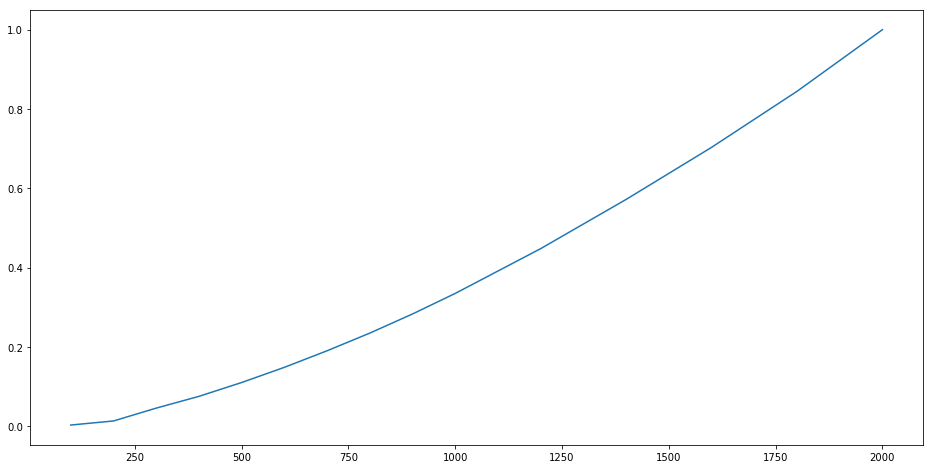

In [40]:
plt.plot(np.append(np.arange(100,1000,100), np.arange(1000,2200,200)), 
         data_m.mean().values)

In [88]:
# (8338, 2)
data = RTO.merge(objects, on=['CFO'])
# (8309, 14)
data = data.merge(households, on=['CFO'])
# (8246, 29)
data = data.merge(competitors, on=['CFO'])
# (7652, 40)
data = data.merge(underground, on=['CFO'],how = 'left')
data = data.merge(roads, on=['CFO'],how = 'left')
data = data.merge(rjd, on=['CFO'],how = 'left')
data = data.merge(parks, on=['CFO'],how = 'left')
data = data.merge(industry, on=['CFO'],how = 'left')
data = data.merge(forest, on=['CFO'],how = 'left')
data = data.merge(dormitories, on=['CFO'],how = 'left')

In [89]:
data['CARFLOW'] = np.log1p(data['CARFLOW'])
data['PARKINGSPOTS'] = np.log1p(data['PARKINGSPOTS'])
data['SCOMMON'] = np.log1p(data['SCOMMON'])
data['STRADING'] = np.log1p(data['STRADING'])
data['Underg_dist'] = np.log1p(data['Underg_dist'])
data['Popul'] = np.log1p(data['Popul'])
data['road_dist1'] = np.log1p(data['road_dist1'])
data['road_dist2'] = np.log1p(data['road_dist2'])
data['road_dist3'] = np.log1p(data['road_dist3'])
data['road_dist4'] = np.log1p(data['road_dist4'])
data['road_dist_high'] = np.log1p(data['road_dist_high'])
data['road_dist_sec'] = np.log1p(data['road_dist_sec'])
data['RZD_dist'] = np.log1p(data['RZD_dist'])
data['RZD_traf'] = np.log1p(data['RZD_traf'])
data['park_dist'] = np.log1p(data['park_dist'])
data['industry_dist'] = np.log1p(data['industry_dist'])
data['forest_dist'] = np.log1p(data['forest_dist'])
data['dormitories_dist'] = np.log1p(data['dormitories_dist'])

In [90]:
data['old'] = (13-data['Open date'].dt.month) + (2016 - data['Open date'].dt.year)*12
data = data.drop(['CFO', 'Open date'], axis=1)

In [91]:
object_columns = data.columns[data.dtypes == "object"]

for col in object_columns:
    lbl = LabelEncoder()
    lbl.fit(list(data[col].values)) 
    data[col] = lbl.transform(list(data[col].values))

---

In [92]:
# object_columns.values, ['INTC', 'ALCOHOLFACT']
categorical_columns = ['OBJECTTYPE', 'CLUSTER', 'REGION', 'MUNICIPALITY', 'LOCALITY', 'INTC', 'SUBFORMAT', 
                       'ALCOHOLFACT', 'Underg', 'RZD', 'station']

---

In [109]:
x_train = data.drop(['рто'], axis=1)
y_train = data['рто']/1e+7

In [55]:
space = {
#     'max_bin' : scope.int(hp.quniform('max_bin', 32, 512, 1)),
    
    'application' : 'regression_l2',
    'boosting_type' : 'gbdt',
    'metric' : 'mse',
    
    'learning_rate' : 0.1,
    'num_leaves' : scope.int(hp.quniform('num_leaves', 16, 64, 1)),

    'max_depth': scope.int(hp.quniform('max_depth', -1, 32, 1)),
    'min_data_in_leaf': scope.int(hp.quniform('min_data_in_leaf', 1, 40, 1)),
#     'min_sum_hessian_in_leaf':2,
    
    'bagging_fraction':hp.quniform('bagging_fraction', 0.4, 1.0, 0.1),
    'feature_fraction':hp.quniform('feature_fraction', 0.4, 1.0, 0.1),

#     'lambda_l1':hp.loguniform('lambda_l1', -10, 0),
#     'lambda_l2':hp.loguniform('lambda_l2', -10, 0),
#     'min_gain_to_split':hp.loguniform('min_gain_to_split', -10, 0),
    
#     'verbose':0,
#     'min_child_weight' : scope.int(hp.quniform('min_child_weight', 1, 10, 1)),
     }

In [56]:
dtrain = lgb.Dataset(x_train, y_train, categorical_feature=categorical_columns)

def score(lgb_params):

#     dtrain = lgb.Dataset(x_train, y_train, max_bin = lgb_params['max_bin'], 
#                          categorical_feature=categorical_columns)
   
    cv_output = lgb.cv(lgb_params, dtrain, nfold=5, num_boost_round=10000, early_stopping_rounds=20, feval=mape,
                                    verbose_eval=None, show_stdv=False, categorical_feature=categorical_columns)
    score = cv_output['mape-mean'][-1]
    print(len(cv_output['l2-mean']), score)
    return {'loss': score, 'status': STATUS_OK, 'round':len(cv_output['l2-mean'])}

In [57]:
%%time
trials = Trials()
best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=10000)

109 0.295244582648
219 0.290031216042
117 0.294248043267
206 0.295523536613
131 0.292277439994
305 0.294525051273
177 0.290056899906
187 0.296136782526
190 0.290991923641
182 0.290402341913
141 0.296174507414
188 0.287953558477
278 0.287461193843
828 0.297762291429
151 0.295121879048
292 0.288008359415
275 0.28773144994
226 0.29295854916
222 0.292859891829
152 0.288480934043
336 0.297133651641
215 0.288667600218
194 0.290491343316
268 0.286904894225
131 0.291666114239
156 0.303002415156
210 0.287675366364
173 0.289010977137
167 0.29218158106
158 0.305253509555
219 0.29229929782
302 0.28730667516
187 0.28849836668
179 0.290935604781
304 0.286828114368
109 0.295997784632
263 0.288209520822
134 0.290443633201
158 0.293245545684
211 0.29306034769
197 0.294391562368
155 0.292589641489
205 0.289125203219
1324 0.315364606705
287 0.287483993655
169 0.290648207096
272 0.29047447069
214 0.290720922541
291 0.287346578524
220 0.288958951742
467 0.295383393564
193 0.295484944183
121 0.2986816479
18

In [58]:
params = pd.DataFrame(trials.trials)['misc'].apply(pd.Series)['vals'].apply(pd.Series)
results=pd.DataFrame()
for col in params.columns:
    results[col] = params[col].apply(pd.Series)[0]
results['loss'] = trials.losses()
results['rank'] = results['loss'].rank()

results.sort_values('rank')

,bagging_fraction,feature_fraction,max_depth,min_data_in_leaf,num_leaves,loss,rank
9806,0.5,0.7,9.0,2.0,20.0,0.282959,49.0
9831,0.5,0.7,9.0,2.0,20.0,0.282959,49.0
9670,0.5,0.7,9.0,2.0,20.0,0.282959,49.0
9220,0.5,0.7,9.0,2.0,20.0,0.282959,49.0
9360,0.5,0.7,9.0,2.0,20.0,0.282959,49.0
9783,0.5,0.7,9.0,2.0,20.0,0.282959,49.0
9405,0.5,0.7,9.0,2.0,20.0,0.282959,49.0
9487,0.5,0.7,9.0,2.0,20.0,0.282959,49.0
8938,0.4,0.7,9.0,2.0,20.0,0.282959,49.0
9386,0.5,0.7,9.0,2.0,20.0,0.282959,49.0


In [22]:
def mape(preds, dtrain):
    return [('mape', np.mean(np.abs(dtrain.get_label()-preds)/dtrain.get_label()), False)]


In [23]:
best_params = {
    
    'application' : 'regression_l2',
    'boosting_type' : 'gbdt',
    'metric' : 'mse',
    
    'learning_rate' : 0.1,
    'num_leaves' : 20,

    'max_depth': 9,
    'min_data_in_leaf': 2,
    
    'bagging_fraction':0.5,
    'feature_fraction':0.7,
}

In [110]:
# best_params = space_eval(space, best)

dtrain = lgb.Dataset(x_train, y_train, max_bin = 255, 
                     categorical_feature=categorical_columns)

cv_output = lgb.cv(best_params, dtrain, nfold=5, num_boost_round=1000, early_stopping_rounds=20, feval=mape,
                                verbose_eval=None, show_stdv=False, categorical_feature=categorical_columns)

num_boost_round = len(cv_output['l2-mean'])
print(num_boost_round, cv_output['mape-mean'][-1])


# model = lgb.train(best_params, dtrain, num_boost_round=num_boost_round, categorical_feature=categorical_columns)
# y_predict = model.predict(x_test)

# 364 0.280803330164

364 0.280803330164


In [111]:
model = lgb.train(best_params, dtrain, num_boost_round=364, 
                    verbose_eval=None, categorical_feature=categorical_columns)

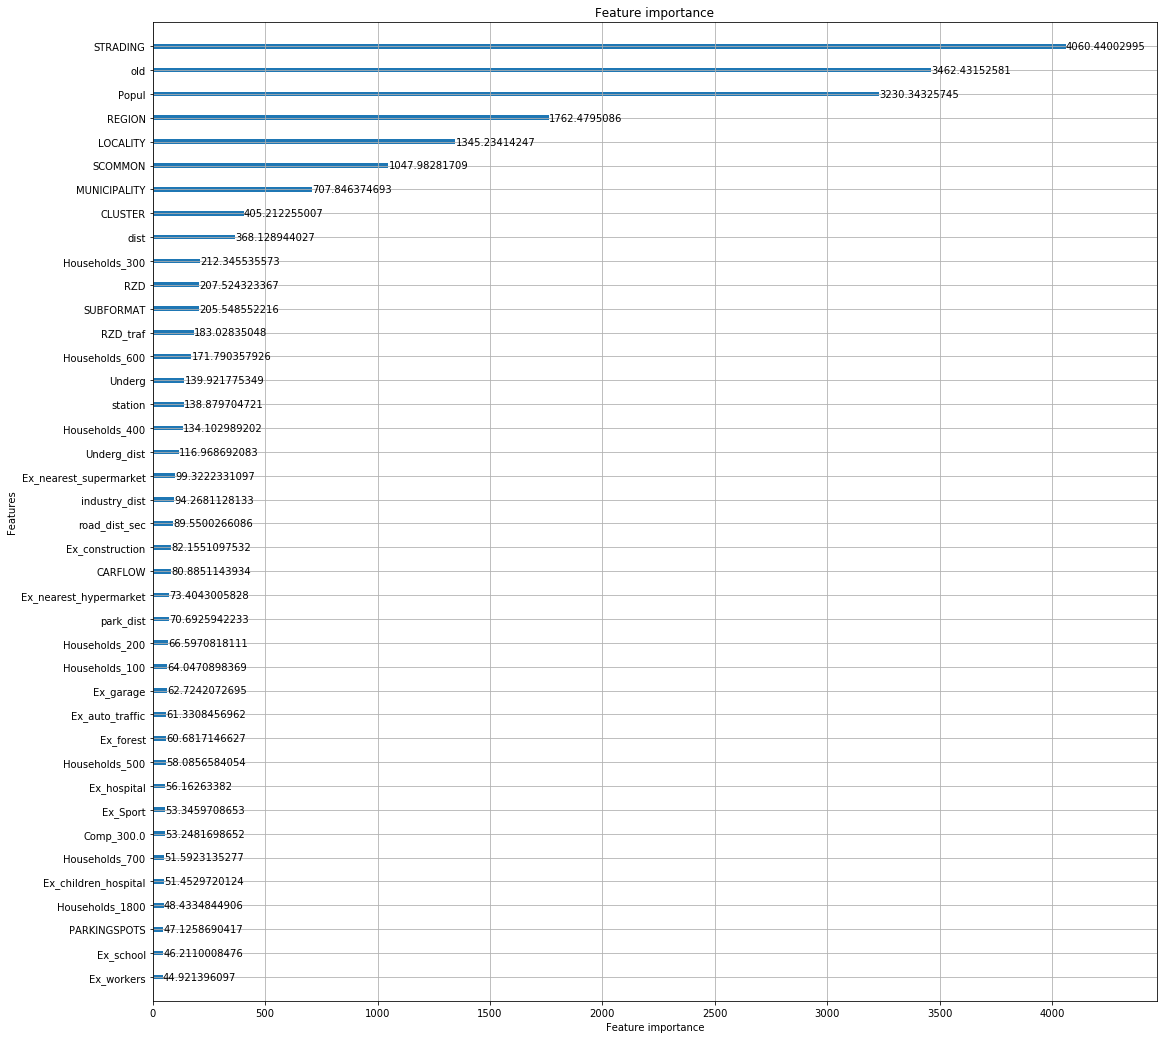

In [112]:
lgb.plot_importance(model, importance_type='gain', max_num_features=40, figsize=(18, 18))

---

In [165]:
# test 
gain_raw = pd.read_csv("Окружение/gain.csv", sep=';')
# gain = gain_raw[['CFO', 'РТО Развитие', 'РТО Факт (день)']]

# print(test.shape)
gain_raw.head(1)

,uid,rev_jan_2010,rev_feb_2010,rev_mar_2010,rev_apr_2010,rev_may_2010,rev_jun_2010,rev_jul_2010,rev_aug_2010,rev_sep_2010,rev_oct_2010,rev_nov_2010,rev_dec_2010,rev_jan_2011,rev_feb_2011,rev_mar_2011,rev_apr_2011,rev_may_2011,rev_jun_2011,rev_jul_2011,rev_aug_2011,rev_sep_2011,rev_oct_2011,rev_nov_2011,rev_dec_2011,rev_jan_2012,rev_feb_2012,rev_mar_2012,rev_apr_2012,rev_may_2012,rev_jun_2012,rev_jul_2012,rev_aug_2012,rev_sep_2012,rev_oct_2012,rev_nov_2012,rev_dec_2012,rev_jan_2013,rev_feb_2013,rev_mar_2013,rev_apr_2013,rev_may_2013,rev_jun_2013,rev_jul_2013,rev_aug_2013,rev_sep_2013,rev_oct_2013,rev_nov_2013,rev_dec_2013,rev_jan_2014,rev_feb_2014,rev_mar_2014,rev_apr_2014,rev_may_2014,rev_jun_2014,rev_jul_2014,rev_aug_2014,rev_sep_2014,rev_oct_2014,rev_nov_2014,rev_dec_2014,rev_jan_2015,rev_feb_2015,rev_mar_2015,rev_apr_2015,rev_may_2015,rev_jun_2015,rev_jul_2015,rev_aug_2015,rev_sep_2015,rev_oct_2015,rev_nov_2015,rev_dec_2015,rev_jan_2016,rev_feb_2016,rev_mar_2016,rev_apr_2016,rev_may_2016,rev_jun_2016,rev_jul_2016,rev_aug_2016,rev_sep_2016,rev_oct_2016,rev_nov_2016,rev_dec_2016,rev_jan_2017,rev_feb_2017,rev_mar_2017,rev_apr_2017,check_jan_2010,check_feb_2010,check_mar_2010,check_apr_2010,check_may_2010,check_jun_2010,check_jul_2010,check_aug_2010,check_sep_2010,check_oct_2010,check_nov_2010,check_dec_2010,check_jan_2011,check_feb_2011,check_mar_2011,check_apr_2011,check_may_2011,check_jun_2011,check_jul_2011,check_aug_2011,check_sep_2011,check_oct_2011,check_nov_2011,check_dec_2011,check_jan_2012,check_feb_2012,check_mar_2012,check_apr_2012,check_may_2012,check_jun_2012,check_jul_2012,check_aug_2012,check_sep_2012,check_oct_2012,check_nov_2012,check_dec_2012,check_jan_2013,check_feb_2013,check_mar_2013,check_apr_2013,check_may_2013,check_jun_2013,check_jul_2013,check_aug_2013,check_sep_2013,check_oct_2013,check_nov_2013,check_dec_2013,check_jan_2014,check_feb_2014,check_mar_2014,check_apr_2014,check_may_2014,check_jun_2014,check_jul_2014,check_aug_2014,check_sep_2014,check_oct_2014,check_nov_2014,check_dec_2014,check_jan_2015,check_feb_2015,check_mar_2015,check_apr_2015,check_may_2015,check_jun_2015,check_jul_2015,check_aug_2015,check_sep_2015,check_oct_2015,check_nov_2015,check_dec_2015,check_jan_2016,check_feb_2016,check_mar_2016,check_apr_2016,check_may_2016,check_jun_2016,check_jul_2016,check_aug_2016,check_sep_2016,check_oct_2016,check_nov_2016,check_dec_2016,check_jan_2017,check_feb_2017,check_mar_2017,check_apr_2017
0,13136,0,0,0,0,0,0,0,0,0,0,0,"6258903,67","5184056,1","6671673,03","8771187,01","8134863,1","7401299,33","6672451,99","6380851,59","6762426,65","8130151,44","9587857,29","9620891,41","11315125,15","9081735,13","9830727,68","10233364,67","9608431,9","10129388,92","9701090,45","8662078,37","7853227,27","8674311,3","8872084,35","8774577,93","10214072,72","8749407,24","9107207,68","10670274,28","9985191,71","10166709,59","9882771,55","8737808,72","8315657,4","8657064,71","9648682,68","10044909,17","11800432,69","9464406,24","10396927,8","12393902,23","12157332,35",12473321,"11411057,16","11003575,92","10340610,89","11465134,32","12506943,37","13183265,07","15812593,37","13022973,4","14176978,56","16576535,2","15591497,36","16022764,55","14995448,79","13329365,03","12980782,99","14060945,64","15316945,71","14498423,75","16265211,49","11 830 309,73","5643253,59","15602730,75","13554679,8","13346259,58","12544314,93","11515332,99","10866776,9","10994494,45","11991408,14","13109707,56","14858766,91","12528852,19","13352125,79","14965887,02","13901797,11",0,0,0,0,0,0,0,0,0,0,0,21968,21367,25808,33758,33446,33198,30863,30399,32745,36238,41819,39338,41039,35454,36641,39772,39571,42742,408,37429,34775,3626,36048,34982,3549,32907,33767,38426,38101,38763,38249,34166,32755,33305,37066,35681,37127,32111,33906,41155,40581,40989,38179,37003,35765,39973,41246,40685,42972,37257,39505,46621,45151,45948,4413,3946,38305,41371,42384,38839,39607,30411,13161,40188,36129,36043,34026,31002,29923,29609,33435,32888,34958,31134,32179,3

In [166]:
gain_raw.shape

(1170, 177)

In [167]:
x_train.head(1)

,OBJECTTYPE,CLUSTER,REGION,MUNICIPALITY,LOCALITY,INTC,CARFLOW,PARKINGSPOTS,SUBFORMAT,SCOMMON,STRADING,ALCOHOLFACT,Popul,Households 100,Households 200,Households 300,Households 400,Households 500,Households 600,Households 700,Households 800,Households 900,Households 1000,Households 1200,Households 1400,Households 1600,Households 1800,Households 2000,Comp 0.0,Comp 100.0,Comp 200.0,Comp 300.0,Comp 400.0,Comp 500.0,Comp 600.0,Comp 700.0,Comp 800.0,Comp 900.0,Comp 1000.0,Underg_dist,Underg,road_dist1,road_dist2,road_dist3,road_dist4,road_dist_high,road_dist_sec,RZD_dist,RZD,station,RZD_traf,park_dist,industry_dist,forest_dist,dormitories_dist,old
0,2,105,30,1105,1026,NaN,0.0,0.0,5,6.946014,6.499787,1,13.139983,16,64,243,640,1246,1893,2255,2577,3069,3557,5744,7960,8935,9451,10014,0.0,3.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,2.0,0.0,NaN,0,NaN,NaN,3.672532,4.03415,NaN,3.672532,6.550974,11,1107,1.998774,6.343914,5.677709,NaN,NaN,109


---

In [116]:
# test 
test_raw = pd.read_excel("Окружение/objects_180417_rto.xlsx")
test = test_raw[['CFO', 'RTOOPER', 'РТО Факт (день)']]

print(test.shape)
test.head(1)

(8418, 3)


,CFO,RTOOPER,РТО Факт (день)
0,E1009288,NaN,156538.0


In [122]:
test = test[test[['RTOOPER', 'РТО Факт (день)']].notnull().all(axis=1)]
test = test[(test[['RTOOPER', 'РТО Факт (день)']]!=0).all(axis=1)]


In [126]:
np.mean(np.abs(test['РТО Факт (день)'] - test['RTOOPER']/30.4)/test['РТО Факт (день)'])

0.40537091418088544

In [127]:
test_merge = RTO.merge(test, on=['CFO'])
np.mean(np.abs(test_merge['рто'] - test_merge['RTOOPER'])/test_merge['рто'])

0.424074611632139

In [129]:
# test 
test_raw = pd.read_excel("Окружение/objects_rto300517.xlsx")
test = test_raw.copy()

test['РТО pred'] = test['РТО Согласованный, руб./мес.'].fillna(test['РТО Развитие, руб./мес.'])
test = test[test['РТО Факт, руб./мес.']>0]
print(test.shape)
test.head(1)

(9221, 8)


,CFO,STATUS,ADDRESS,STRADING,"РТО Развитие, руб./мес.","РТО Согласованный, руб./мес.","РТО Факт, руб./мес.",РТО pred
0,E1009288,Открыт,"ст-ца Кавказская, Ленина ул., 187",314,5324479,NaN,4826699.2,5324479.0


In [132]:
test = test[test[['РТО Согласованный, руб./мес.', 'РТО Факт, руб./мес.']].notnull().all(axis=1)]
test = test[(test[['РТО Согласованный, руб./мес.', 'РТО Факт, руб./мес.']]!=0).all(axis=1)]

In [134]:
test.shape

(2548, 8)

In [137]:
np.mean(np.abs(test['РТО Факт, руб./мес.'] - test['РТО Согласованный, руб./мес.'])/test['РТО Факт, руб./мес.'])

0.39888860083954525

In [138]:
np.median(np.abs(test['РТО Факт, руб./мес.'] - test['РТО Согласованный, руб./мес.'])/test['РТО Факт, руб./мес.'])

0.27335036683376457